# Dynamic breakpoints 

## Review

We disussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like approval

We also showed how to edit graph state. 

## Goals

We covered breakpoints set by the developer before or after a node is executed. 

But oftentimes it may be helpful to **dynamically interrupt** the graph from inside a given node based on some condition. 

This is basically an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

Let's create a graph where a `NodeInterrupt` is thrown based upon lenth of the input.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

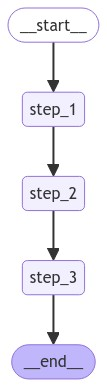

In [3]:
from IPython.display import Image, display

from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [4]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we can see the information on what node is set to execute next (`step_2`).


In [5]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that this is logged to state.

In [11]:
print(state.tasks)

(PregelTask(id='8dbf0559-ed33-575a-847e-3461f6e3daa5', name='step_2', error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),)),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

Let's try to resume.

In [12]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

In [13]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [15]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64a23-e6dd-6180-8002-a294a4c1757c'}}

In [16]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}
